# Library Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import json
import pandas as pd

# Chart Option Class 

In [2]:
class MyChartOption:
    def __init__(self, jsonString):
        self.json = json.loads(jsonString)
    
    def getOption(self, option_name):
        tokens = option_name.split('.')
        value = self.json
        for token in tokens:
            if token in value:
                value = value[token]
            else: 
                return None
        return value
    
    def isExist(self, option_name):
        tokens = option_name.split('.')
        value = self.json
        for token in tokens:
            if token in value:
                value = value[token]
            else: 
                return False
        return True

# Calculate Band

In [3]:
def calculateBand(df, window_size=1, sigma=2.0):
    df['MA'] = df['Y'].rolling(window=window_size).mean()
    df['STD'] = df['Y'].rolling(window=window_size).std()
    df['U_band'] = df['MA'] + (df['STD'] * sigma)
    df['L_band'] = df['MA'] - (df['STD'] * sigma)
    return df

# Draw Chart

In [4]:
def drawMABandPlotChart(X, Y, title, window_size, sigma, options):    
    """
    Set style option
    """
    if options.isExist('style'):
        plt.style.use(options.getOption('style'))
    
    """
    Set figure options
    """
    if options.isExist('fig'):
        fig_size_x = options.getOption('fig.x_size')
        fig_size_y = options.getOption('fig.y_size')
        
    """
    Set legend options
    """
    if options.isExist('legend'):
        legend_loc = options.getOption('legend.loc')

    """
    Set color map
    """
    if options.isExist('color'):
        color_map = []
        if (options.isExist('color.pallete')):
            color_map = options.getOption('color.pallete')
        elif (options.isExist('color.map')):
            color_norm = colors.Normalize(vmin=0, vmax=3)
            scalar_map = cmx.ScalarMappable(norm=color_norm, cmap = options.getOption('color.map'))       
            for i in range(3):
                color_map.append(scalar_map.to_rgba(i))
    """
    Set axes options
    """
    if options.isExist('axes'):
        axes_alpha = options.getOption('axes.alpha')
        axes_format = options.getOption('axes.format')
        axes_markersize = options.getOption('axes.markersize')
        axes_linewidth = options.getOption('axes.linewidth')
        
    """
    Set band options
    """
    if options.isExist('band'):
        band_fill_color = options.getOption('band.fill_color')
        band_fill_alpha = options.getOption('band.fill_alpha')
        
    frame = {
        'X': X, 
        'Y': Y
    }
    
    df = pd.DataFrame(frame, columns=frame.keys())
    
    mv_df = calculateBand(df, window_size, sigma)
        
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size_x, fig_size_y)  
    ax.set_title(title)
        
    ax.fill_between(mv_df['X'], 
                    mv_df['U_band'], 
                    mv_df['L_band'], 
                    alpha=band_fill_alpha,
                    color=band_fill_color)

    # Draw 'Y' values
    ax.plot(mv_df['X'], mv_df['Y'], 
            axes_format,
            lw=axes_linewidth, 
            alpha=axes_alpha,
            color=color_map[0],
            label='Y-value')
    
    # Draw Moving Average
    ax.plot(mv_df['X'], mv_df['MA'], 
        axes_format,
        lw=axes_linewidth, 
        alpha=axes_alpha,
        color=color_map[1],
        label=str(window_size) + ' MA')
    
    ax.legend(loc = legend_loc, fontsize='small')
    plt.show()

# Get Stock Price in YAHOO  

In [5]:
from pandas_datareader import data
import pandas as pd
import pprint
from datetime import datetime
def getStockHistory(companyCode, fromDate, toDate):
    dataSource = 'yahoo'
    storeList = []
    ticker = companyCode
    print('===========>Call ' + ticker)
    try:
        start = pd.to_datetime(fromDate).date()
        end = pd.to_datetime(toDate).date()
        panel_data = data.DataReader(ticker, dataSource, start, end)
    except:
        print(ticker + ' ommit')
        return
    panel_data = panel_data.transpose()
    if len(panel_data) > 0:
        for stock_data in panel_data:
                storeDic = {}
                #print stock_data
                storeDic["code"] = ticker
                storeDic["s_date"] = stock_data
                #storeDic["adj_close"] = stock_data["Adj Close"]
                storeDic["s_close"] = panel_data[stock_data]["Close"]
                storeDic["s_open"] = panel_data[stock_data]["Open"]
                storeDic["s_high"] = panel_data[stock_data]["High"]
                storeDic["s_low"] = panel_data[stock_data]["Low"]
                storeDic["s_volume"] = panel_data[stock_data]["Volume"]
                storeList.append(storeDic)
                #pprint.pprint(storeDic)
    else:
        print (ticker + ' does not exist')
    print ('===========>END ' + ticker)   
    
    return storeList

###  015260.KS price

In [6]:
storeList = getStockHistory('015260.KS', '2017-11-01', '2018-11-01')

===========>Call 015260.KS
===========>END 015260.KS


## Make & Merge Dataframe 

In [7]:
df_data = pd.DataFrame(storeList, columns=storeList[0].keys())

In [8]:
df_data.head()

,code,s_date,s_close,s_open,s_high,s_low,s_volume
0,015260.KS,2017-11-01,1036.579956,1045.189941,1049.489990,1019.380005,2286244.0
1,015260.KS,2017-11-02,1066.689941,1040.890015,1066.689941,1027.979980,3665545.0
2,015260.KS,2017-11-03,1049.489990,1092.500000,1101.099976,1049.489990,3829817.0
3,015260.KS,2017-11-06,1006.479980,1036.579956,1040.890015,997.872986,2348832.0
4,015260.KS,2017-11-07,1015.080017,1006.479980,1036.579956,1002.169983,1866423.0


## Set Chart Option 

####  현재까지 사용가능한 옵션들
* style
    Style 옵션은 "plt.style.available"에서 확인할 수 있다. 
    <br>
     'seaborn-dark',
     'seaborn-darkgrid',
     'seaborn-ticks',
     'fivethirtyeight',
     'seaborn-whitegrid',
     'classic',
     '_classic_test',
     'fast',
     'seaborn-talk',
     'seaborn-dark-palette',
     'seaborn-bright',
     'seaborn-pastel',
     'grayscale',
     'seaborn-notebook',
     'ggplot',
     'seaborn-colorblind',
     'seaborn-muted',
     'seaborn',
     'Solarize_Light2',
     'seaborn-paper',
     'bmh',
     'seaborn-white',
     'dark_background',
     'seaborn-poster',
     'seaborn-deep'
* fig
    <br/>x_size
    <br/>y_size
* lenged
    <br/>loc
* axes
    <br/>format
    <br/>alpha
    <br/>markersize
    <br/>linewidth
* color 
    <br/>
    Color 옵션은 map 또는 pallete 를 정의한다. 두 개다 있을 경우에는 pallete 가 우선 적용된다. 
    <br/> Color는 2가지 색을 정의하고 0:Y-value, 1:Moving Average로 사용된다. 
* bnad
    <br/> fill_color
    <br/> fill_alpha

In [9]:
options = '''{
    "style":"bmh", 
    "fig": {"x_size": 12, "y_size": 6}, 
    "legend":{"loc":"upper right"},
    "axes":{"format":"-","alpha":0.7, "markerisze":5, "linewidth":2}, 
    "color":{"pallete":["#173F5F", "#ED553B"]},
    "band":{"fill_color":"#F6D55C", "fill_alpha":0.5}
    }'''
# "color":{"map":"viridis"}
# "color":{"pallete":["#173F5F", "#20639B", "#3CAEA3", "#F6D55C", "#ED553B"]}
op = MyChartOption(options)
op.getOption('fig.x_size')

12

## Call Draw Chart 

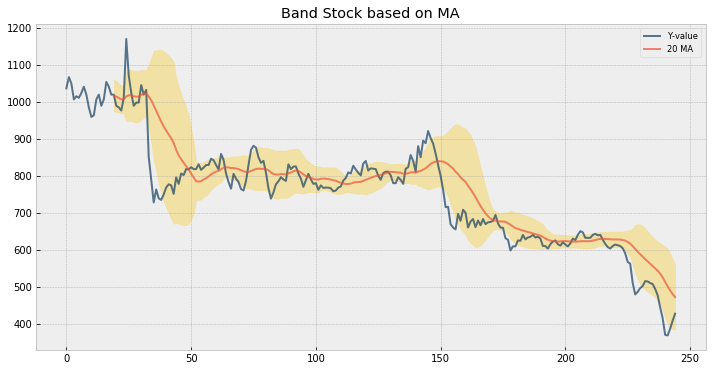

In [10]:
title = 'Band Stock based on MA'
x = np.array(df_data.index.tolist())
y = np.array(df_data['s_close'].tolist())
window_size = 20
sigma = 1.5
drawMABandPlotChart(x, y, title, window_size, sigma, op)